In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

np.random.seed(2)

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
import keras.optimizers as opt
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers.core import Dropout, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers import Input

In [20]:
data = pd.read_csv("fer2013.csv")
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [21]:
groups = [g for _, g in data.groupby('Usage')]
train = groups[2]
val = groups[1]
test = groups[0]

In [22]:
train = train.drop(labels=['Usage'], axis=1)
val = val.drop(labels=['Usage'], axis=1)
test = test.drop(labels=['Usage'], axis=1)

Y_train = train["emotion"]
Y_val = val["emotion"]
Y_test = test["emotion"]
#'Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'#

X_train = train["pixels"]
X_val = val["pixels"]
X_test = test["pixels"]

In [23]:
def preprocess(X):
    X = np.array([np.fromstring(image, np.uint8, sep=' ') for image in X])
    X = X/255.0
    X = X.reshape(-1, 48, 48, 1)
    return X

In [24]:
X_train = preprocess(X_train)
X_val = preprocess(X_val)
X_test = preprocess(X_test)

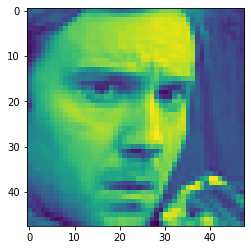

In [25]:
plt.imshow(X_train[0][:,:,0])

Text(0.5, 1.0, 'Counts per emotion in testing set')

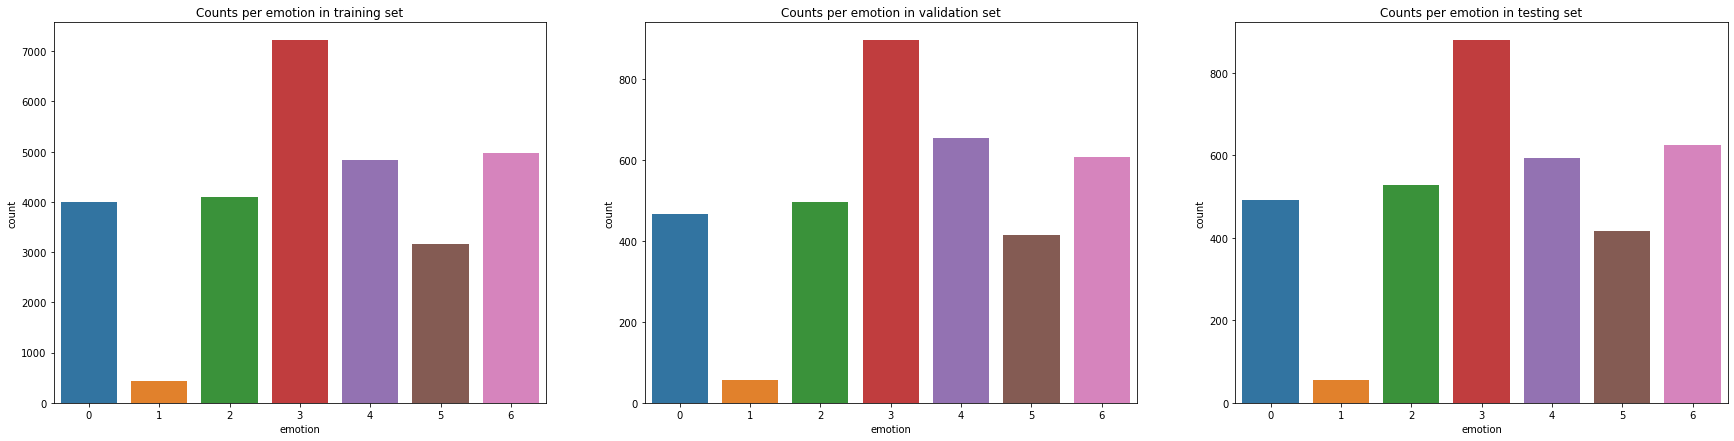

In [26]:
plt.figure(figsize=(30, 7))

plt.subplot(1,3,1)
ax = sns.countplot(Y_train)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in training set")

plt.subplot(1,3,2)
ax = sns.countplot(Y_val)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in validation set")

plt.subplot(1,3,3)
ax = sns.countplot(Y_test)
ax.set(ylabel="count", xlabel="emotion")
plt.title("Counts per emotion in testing set")

In [27]:
print("Is any label null in training set:", Y_train.isnull().any())
print("Is any label null in validation set:", Y_val.isnull().any())
print("Is any label null in testing set:", Y_test.isnull().any())


Y_train = to_categorical(Y_train, num_classes=7)
Y_val = to_categorical(Y_val, num_classes=7)
Y_test = to_categorical(Y_test, num_classes=7)

Is any label null in training set: False
Is any label null in validation set: False
Is any label null in testing set: False


In [28]:
model = Sequential()
model.add(Conv2D(32, (3,3), padding="Same", activation='relu', input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Conv2D(32, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2))) 
model.add(Dropout(0.5))
model.add(Conv2D(128, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2))) 
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [29]:
optimizer = opt.Adam(lr = 0.001)
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)

In [30]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
history = model.fit(X_train, Y_train, validation_data=[X_val, Y_val], epochs=50, batch_size = 100, callbacks=[lr_anneal])

Train on 28709 samples, validate on 3589 samples
Epoch 1/50
28709/28709 [==============================] - 10s 353us/step - loss: 2.0378 - accuracy: 0.2675 - val_loss: 1.8202 - val_accuracy: 0.2494
Epoch 2/50
28709/28709 [==============================] - 9s 321us/step - loss: 1.6272 - accuracy: 0.3564 - val_loss: 1.6487 - val_accuracy: 0.3739
Epoch 3/50
28709/28709 [==============================] - 9s 316us/step - loss: 1.4496 - accuracy: 0.4314 - val_loss: 1.5052 - val_accuracy: 0.4355
Epoch 4/50
28709/28709 [==============================] - 9s 308us/step - loss: 1.3399 - accuracy: 0.4773 - val_loss: 1.3461 - val_accuracy: 0.4834
Epoch 5/50
28709/28709 [==============================] - 9s 310us/step - loss: 1.2772 - accuracy: 0.5023 - val_loss: 1.2610 - val_accuracy: 0.5169
Epoch 6/50
28709/28709 [==============================] - 9s 310us/step - loss: 1.2309 - accuracy: 0.5226 - val_loss: 1.2579 - val_accuracy: 0.5155
Epoch 7/50
28709/28709 [==============================] - 9s 3

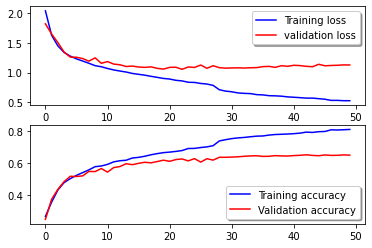

In [33]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

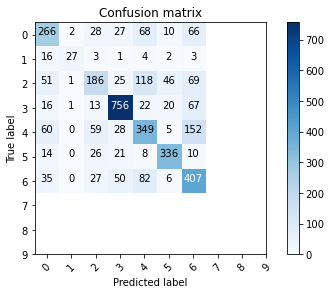

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

In [17]:
score, acc = model.evaluate(X_test, Y_test, batch_size=100)
print('Test score:', score)
print("Test accuracy:", acc)

3589/3589 [==============================] - 0s 106us/step
Test score: 1.0651215350073207
Test accuracy: 0.6478127837181091
